In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/home/nkotelevskii/github/corrected_l2hmc/l2hmc_pytorch/l2hmc/utils/')

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from tqdm import tqdm
import itertools

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.distributions_pt import GMM #random_tilted_gaussian, Gaussian, GMM, RoughWell

import seaborn as sns
sns.set_palette("muted")

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
from func_utils_pt import acl_spectrum, ESS
from distributions_pt import Gaussian
from layers_pt import Net
from dynamics_pt import Dynamics
from sampler_pt import propose
from notebook_utils_pt import get_hmc_samples
import random

from IPython.core.debugger import set_trace

In [4]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(0)   
# random.seed(0)

In [5]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [6]:
network = Net


---
# Mixture of Gaussians (MoG)

## Defining the distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [7]:
x_dim = 2
mu_1 = np.array([-2., 0.])
mu_2 = np.array([2., 0.])
mus = np.array([mu_1, mu_2])
cov_1 = 0.1 * np.eye(2)
cov_2 = 0.1 * np.eye(2)
covs = np.array([cov_1, cov_2])
pis = np.array([0.5, 0.5])
dist = GMM(mus, covs, pis)

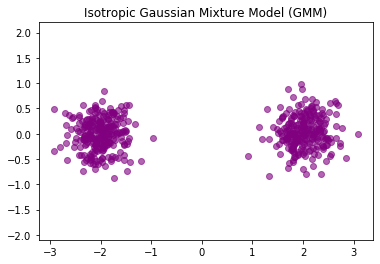

In [8]:
S = dist.get_samples(500)
fig = plt.figure()
plt.title('Isotropic Gaussian Mixture Model (GMM)')
# plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-3,3], y_lims=[-2,2])
plt.plot(S[:, 0], S[:, 1], 'o', alpha=0.6, color=c_true)
plt.axis('equal')
plt.show()
# fig.savefig('iso_gmm_exact.png', dpi=200)

---
## Training

In [9]:
dynamics = Dynamics(x_dim, dist.get_energy_function(), T=10, eps=0.1, net_factory=network, use_temperature=True).to(device)

In [10]:
n_steps = 5000
n_samples = 200

In [11]:
optim = Adam(itertools.chain(dynamics.XNet.parameters(), dynamics.VNet.parameters()))
scheduler = StepLR(optim, step_size=1000, gamma=0.96)
scale = torch.tensor(0.1).to(device)

def criterion(v1, v2):
    return scale * (torch.mean(1.0 / v1) + torch.mean(1.0 / v2)) + (-torch.mean(v1) - torch.mean(v2)) / scale

# with torch.autograd.detect_anomaly():
for t in tqdm(range(n_steps)):
    tmp = 9.0 * (1 - t / float(n_steps)) + 1
    if(t==0):
        x = torch.randn(n_samples, x_dim, dtype=torch.float32).to(device)
    else:
        x = output[0].detach().to(device)

    z = torch.randn_like(x).to(device)

    x.requires_grad_(False)
    z.requires_grad_(False)

    optim.zero_grad()
    Lx, _, px, output = propose(x, dynamics, do_mh_step=True, temperature=tmp)
    Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False, temperature=tmp)

    v1 = (torch.sum((x - Lx)**2, dim=1) * px) + torch.tensor(1e-4).to(device)
    v2 = (torch.sum((z - Lz)**2, dim=1) * pz) + torch.tensor(1e-4).to(device)

    loss = criterion(v1, v2)
    
#     with torch.autograd.detect_anomaly():
#     set_trace()
    loss.backward()

    optim.step()
    if t % 50 == 0:
        print('v1', v1.max())
        print('v2', v2.max())
        current_lr = None
        for param_group in optim.param_groups:
            current_lr = param_group['lr']
        print ('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss.item(), np.mean(px.cpu().detach().numpy()), current_lr))
    scheduler.step()
    optim.zero_grad()

  0%|          | 1/5000 [00:00<21:49,  3.82it/s]

v1 tensor(42.2382, device='cuda:0', grad_fn=<MaxBackward1>)
v2 tensor(69.3864, device='cuda:0', grad_fn=<MaxBackward1>)
Step: 0 / 5000, Loss: -4.32e+01, Acceptance sample: 0.68, LR: 0.00100


  1%|          | 51/5000 [00:13<20:59,  3.93it/s]

v1 tensor(15225.8770, device='cuda:0', grad_fn=<MaxBackward1>)
v2 tensor(95.9796, device='cuda:0', grad_fn=<MaxBackward1>)
Step: 50 / 5000, Loss: -5.62e+03, Acceptance sample: 0.35, LR: 0.00100


  2%|▏         | 101/5000 [00:26<21:03,  3.88it/s]

v1 tensor(140889.1875, device='cuda:0', grad_fn=<MaxBackward1>)
v2 tensor(148.0251, device='cuda:0', grad_fn=<MaxBackward1>)
Step: 100 / 5000, Loss: -5.20e+04, Acceptance sample: 0.39, LR: 0.00100


  2%|▏         | 122/5000 [00:31<20:52,  3.89it/s]

KeyboardInterrupt: 